In [1]:
import numpy as np
import pandas as pd

In [273]:
#path = 'E:\\dtuklaptop\\e\\Users\\Mat\\python\\14. property\\RSACapital\\'
path = 'E:\\dtuklaptop\\e\\Users\\Mat\\python\\data\\property\\processed\\'

def strip(df):
    df['Memo']=df['Memo'].str.strip()
    df['Subcategory']=df['Subcategory'].str.strip()
    if 'Description' in df.columns:
        df['Description']=df['Description'].str.strip()
    return df

def load_rs(spreadsheets):
    dfIv = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    dfMt = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    df40 = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo'])
    dfRs = pd.DataFrame()
    for spreadsheet in spreadsheets:
        dfMtTemp=load_worksheet(spreadsheet, 'MT')
        dfMt=pd.concat([dfMt,dfMtTemp]) 
        dfIvTemp=load_worksheet(spreadsheet, 'IV')
        dfIv=pd.concat([dfIv,dfIvTemp])
        df40Temp=load_worksheet(spreadsheet, 'IV (4040)')
        df40=pd.concat([df40,df40Temp])
        dfRsTemp=load_rent_statement(spreadsheet)
        dfRs=pd.concat([dfRs,dfRsTemp]) 
    dfMt=strip(dfMt)
    dfIv=strip(dfIv)
    df40=strip(df40)
    
    dfMt=dfMt.loc[:, ~dfMt.columns.str.contains('^Unnamed')]
    dfIv=dfIv.loc[:, ~dfIv.columns.str.contains('^Unnamed')]
    df40=df40.loc[:, ~df40.columns.str.contains('^Unnamed')]
    
    dfMt=dfMt.set_index('Date')
    dfIv=dfIv.set_index('Date')
    df40=df40.set_index('Date')
    return dfMt, dfIv, df40, dfRs

def categorise_rs(df):
    # Categorise expenses
    # Mortgage, PropertyExpense, OurRent, BealsRent, ServiceCharge
    # SchoolFees, Car, Hilltop, PersonalExpenses, RegularPayment
    global dfUncat
    df["Cat"] = np.nan
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('JASPER|TOPAZ|SIBERITE|MORTGAGE EXPRESS|NRAM|PLATFORM|AMBER|BHAM|CAPITAL|CHL|MORTGAGE TRUST')==True),"Cat"] = 'Mortgage'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*M TUCKER.*STO.*')==True) & (df.Amount > -200) & (df.Amount <-190),"Cat"] = 'Mortgage' # Kingston Rd mortgage
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Description.str.match('Rent for period')==True),"Cat"] = 'OurRent'
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Property.notnull()) & (df.Description.str.match('Rent for period')==False),"Cat"] = 'PropertyExpense'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('BEALS.*BGC')==True),"Cat"] = 'BealsRent'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('23 HAMPSHIRE.*STO|4-6 ALHAMBRA RD CS|12-14 ALHAMBRA RD|16-18 ALHAMBRA RD|ALHAMBRA ROAD MANA')==True),"Cat"] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*HARPUR TRUST.*|.*BEDFORD SCHOOL.*')==True),"Cat"] = 'SchoolFee'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*F VALENTINO.*')==True),"Cat"] = 'Hilltop'
    
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('HMRC')==True),"Cat"] = 'HMRC'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('CCTV|Letterbox',case=False)==True),"Cat"] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT'),"Cat"] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CASH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CRE'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='OTH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='BCC'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REFUND'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CHQ'),'Cat'] = 'PersonalExpense'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*INTERCO.*',case=False)==True),'Cat'] = 'ServiceCharge'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Description.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*13438023.*|.*83672832.*|.*23534332.*|.*13686035.*')==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*63796884.*|.*33631583.*',case=False)==True),'Cat'] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*LAND ROVER.*')==True),"Cat"] = 'Car'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='DIRECTDEBIT'),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('NATIONWIDE|KINGSTON UNITY')==True),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REPEATPMT')&(df.Memo.str.match('.*M TUCKER.*STO.*')==True)&(df.Amount>-100),'Cat'] = 'RegularPayment'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('Sofia|Rocco', case=False)==True),'Cat'] = 'Kids'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*30728691.*')==True),'Cat'] = 'Funds3072'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*40406538 .*')==True),'Cat'] = 'Funds4040'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*60458872.*')==True),'Cat'] = 'Funds6045'

    df.loc[(df.Cat.isnull())&(df.Amount>0),'Cat'] = 'OtherIncome'
    df.loc[(df.Cat.isnull())&(df.Amount<0),'Cat'] = 'OtherExpense'

    return df

def load_worksheet(spreadsheet, worksheet):
    input_file = path + spreadsheet + '.xlsm'
    df = pd.read_excel(input_file,sheet_name=worksheet)
    df.drop('Import', axis=1, inplace=True)
    df.drop('Number', axis=1, inplace=True)
    df = df.astype({"Description": str})
    df = df[~df.Account.isnull()]
    return df

def load_rent_statement(spreadsheet):
    worksheet='Rent Statement'
    input_file = path + spreadsheet + '.xlsm'
    dfSmtDate = pd.read_excel(input_file,sheet_name=worksheet)
    dfSmtDate=dfSmtDate.loc[dfSmtDate['Rental Statement']=='Statement Date:','Unnamed: 1'].iloc[0]

    df = pd.read_excel(input_file,sheet_name=worksheet,header=6)
    df=df.loc[(df['Owner'].notnull())&(df['Owner']!='Alhambra Road Management Ltd')]
    df=df.loc[(df['Property'].notnull())]
    df=df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    df['StatementDate'] = dfSmtDate
    df.drop('Reconciled', axis=1, inplace=True)
    df.drop('Lender', axis=1, inplace=True)
    df.drop('Account No', axis=1, inplace=True)
    df.drop('Property Id', axis=1, inplace=True)
    df.drop('Profit', axis=1, inplace=True)
    df.drop('Net Income', axis=1, inplace=True)
       
    df.update(df.select_dtypes(include=[np.number]).fillna(0))
    df['Profit']=df['Rental Amount']-df['Mgmt Fees']-df['VAT']-df['Bills Paid']-df['Other Bills']
    df['Net Income']=df['Profit']-df['Mortgage Payment']

    return df

def load_barclays(filename):
    input_file = path + filename
    df=pd.read_csv(input_file,names=['Number','Date','Account','Amount','Subcategory','Memo','Memo2'],skiprows=1, index_col=1, parse_dates=True, dayfirst=True)
    df=df.replace('\t','', regex=True)
    # Need to do this because some memo columns contain commas which confuses read_csv
    df['Memo2'] = df['Memo2'].fillna('')
    df['Memo'] = df['Memo'].astype(str) + df['Memo2'].astype(str)
    df.drop(['Memo2','Number'], axis=1, inplace=True)
    #df.set_index('Date')
    df = categorise(df)
    return df

def categorise_barclays(df):
    df["Cat"] = np.nan
    
    # Identify Mortgages
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('JASPER|TOPAZ|SIBERITE|MORTGAGE EXPRESS|NRAM|PLATFORM|AMBER|BHAM|CAPITAL|CHL|MORTGAGE TRUST')==True),"Cat"] = 'Mortgage'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*M TUCKER.*STO.*')==True) & (df.Amount > -200) & (df.Amount <-190),"Cat"] = 'Mortgage' # Kingston Rd mortgage
    
    # Identify Rents
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('BEALS.*BG.*')==True),"Cat"] = 'BealsRent'
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('Funds Transfer|Counter Credit|Standing Order|Bill Payment')==True)&(df.Memo.str.match('.*DEPOSIT.*',case=False)==True),"Cat"] = 'Deposit'
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('Funds Transfer|Counter Credit|Standing Order|Bill Payment')==True)&(df.Memo.str.match('.*RENT.*|.*KUMAR.*|.*LINDEMERE.*|.*SEQUENCE UK.*|.*SOPHIE.*|.*BETTS.*',case=False)==True),"Cat"] = 'OurRent'
    
    # Identify Property Expenses
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('Bill Payment|Funds Transfer|Standing Order')==True)&(df.Memo.str.match('.*PORTSEA.*|.*BECK.*|.*COURT FEE.*|.*ROGERS.*|.*ICE PROFESSIONAL.*|.*SOUTHERN ELEC.*')==True),"Cat"] = 'PropertyExpense'

    # Identify Service Charges and Transfers between accounts
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('23 HAMPSHIRE.*STO|4-6 ALHAMBRA RD CS|12-14 ALHAMBRA RD|16-18 ALHAMBRA RD|ALHAMBRA ROAD MANA')==True),"Cat"] = 'ServiceCharge'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*30728691.*')==True),'Cat'] = 'Funds3072'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*40406538 .*')==True),'Cat'] = 'Funds4040'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*60458872.*')==True),'Cat'] = 'Funds6045'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='Bill Payment')&(df.Amount<0)&(df.Memo.str.match('RSA CAPITAL')==True),"Cat"] = 'OurRent'
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('Funds Transfer')==True)&(df.Memo.str.match('.*FRATTON SC.*|.*FRATTON ROAD.*|.*FRATTON RD.*|.*CREST.*')==True),"Cat"] = 'FrattonRoad'
   
    # Identify Regular Payments
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*HARPUR TRUST.*|.*BEDFORD SCHOOL.*')==True),"Cat"] = 'SchoolFee'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*F VALENTINO.*')==True),"Cat"] = 'Hilltop'
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('Bill Payment|Direct Debit')==True)&(df.Memo.str.match('.*HMRC*.')==True),"Cat"] = 'HMRC'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='Direct Debit'),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*LAND ROVER.*')==True),"Cat"] = 'Car'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('NATIONWIDE|KINGSTON UNITY')==True),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('Spotify')==True),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='Standing Order')&(df.Memo.str.match('.*M TUCKER.*STO.*')==True)&(df.Amount>-100),'Cat'] = 'RegularPayment' # £50 to 1585, £5 to Natwest
    df.loc[(df.Cat.isnull())&(df.Subcategory=='Card Purchase')&(df.Memo.str.match('.*Amazon Prime*',case=False)==True)&(df.Amount==-7.99),'Cat'] = 'RegularPayment'
    
    # Mark rest of card puchases as Personal Expense
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('.*Card Purchase.*|.*Card Refund.*')==True),"Cat"] = 'PersonalExpense'

    return df

def load_starling(filename):
    input_file = path + filename
    df=pd.read_csv(input_file, index_col=0, parse_dates=True, dayfirst=True)
    df['Account'] = '60-83-71 00558156'
    df['Notes'] = df['Notes'].fillna('')
    df['Memo'] = df['Counter Party'] + ' ' + df['Reference']  + ' ' + df['Notes']
    df.rename(columns = {'Amount (GBP)':'Amount','Spending Category':'Subcategory'}, inplace = True)
    df.drop(['Counter Party','Reference','Notes','Balance (GBP)'], axis=1, inplace=True)
    df = df[['Account','Amount','Subcategory','Memo']]
    return df
    
def categorise_starling(df):
    df["Cat"] = np.nan

    # Identify Rents
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('BEALS')==True),"Cat"] = 'BealsRent'
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('REVENUE')==True)&(df.Memo.str.match('.*DEPOSIT.*',case=False)==True),"Cat"] = 'Deposit'
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('REVENUE')==True),"Cat"] = 'OurRent'

    # Identify Expenses
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('WORKPLACE|.*REPAIRS.*|.*MAINTENANCE.*|.*PROFESSIONAL.*')==True),"Cat"] = 'PropertyExpense'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*NRLA.*')==True),"Cat"] = 'PropertyExpense'

    # Identify Withdrawls
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('INTEREST_PAYMENTS')==True),"Cat"] = 'Mortgages'
    df.loc[(df.Cat.isnull())&(df.Subcategory.str.match('DIRECTORS_WAGES|OTHER|OTHER_INCOME')==True),"Cat"] = 'PersonalExpenses'
    return df

def sumOf(df,cat):
    g=pd.Grouper(freq="M")
    return df.loc[df.Cat == cat,'Amount'].groupby(g).sum()

def get_pty_summary(dfMt,dfIv,dfRsa):
    dfPty = pd.DataFrame()
    dfPty['Mortgage']=pd.concat([sumOf(dfMt,'Mortgage'),sumOf(dfIv,'Mortgage'),sumOf(dfRsa,'Mortgage')],axis=1).sum(axis=1)
    dfPty['PropertyExpense']=pd.concat([sumOf(dfMt,'PropertyExpense'),sumOf(dfIv,'PropertyExpense'),sumOf(dfRsa,'PropertyExpense')],axis=1).sum(axis=1)
    dfPty['ServiceCharge']=pd.concat([sumOf(dfMt,'ServiceCharge'),sumOf(dfIv,'ServiceCharge'),sumOf(dfRsa,'ServiceCharge')],axis=1).sum(axis=1)
    dfPty['OurRent']=pd.concat([sumOf(dfMt,'OurRent'),sumOf(dfIv,'OurRent'),sumOf(dfRsa,'OurRent')],axis=1).sum(axis=1)
    dfPty['BealsRent']=pd.concat([sumOf(dfMt,'BealsRent'),sumOf(dfIv,'BealsRent'),sumOf(dfRsa,'BealsRent')],axis=1).sum(axis=1)
    
    dfPty = dfPty.fillna(0)
    
    dfPty['TotalRent']=dfPty['OurRent'] + dfPty['BealsRent']
    dfPty['NetProfit']=dfPty['OurRent'] + dfPty['BealsRent'] + dfPty['Mortgage'] + dfPty['PropertyExpense'] + dfPty['ServiceCharge']
    return dfPty

def plot_properties(dfPty, start, end):
    dfBar=pd.DataFrame()
    dfBar['OurRent'] = dfPty.loc[start:end]['OurRent']
    dfBar['BealsRent'] = dfPty.loc[start:end]['BealsRent']
    dfBar['Mortgage'] = abs(dfPty.loc[start:end]['Mortgage'])
    dfBar['PropertyExpense'] = abs(dfPty.loc[start:end]['PropertyExpense'])
    dfBar['ServiceCharge'] = abs(dfPty.loc[start:end]['ServiceCharge'])
    dfBar.index = dfBar.index.strftime('%b %y')

    ax = dfBar[['Mortgage','PropertyExpense','ServiceCharge']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange'])
    ax.axhline(5000, color="gray",linestyle='--')
    ax.axhline(10000, color="gray",linestyle='--')
    dfBar[['BealsRent','OurRent']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['green','darkgreen'],figsize=(30,15),fontsize=20)


In [274]:
spreadsheets=[ \
              'Beals_RentalStatement_APR2022_21062022_2173', 'Beals_RentalStatement_MAY2022_21062022_2174'              
             ]

dfMt, dfIv, df40, dfRs = load_rs(spreadsheets)
dfIv=categorise_rs(dfIv)
dfMt=categorise_rs(dfMt)
df40=categorise_rs(df40)

C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [284]:
dfMt2=categorise_barclays(load_barclays('BC_6045_AUG22.csv'))
dfIv2=categorise_barclays(load_barclays('BC_3072_AUG22.csv'))
dfRsa=categorise_starling(load_starling('StarlingStatement_2022-08.csv'))

### Merge Pre/Post RSA Capital data

In [285]:
dfMt2['Property']=''
dfMt2['Description']=''
dfMt2=dfMt2[['Account','Amount','Subcategory','Memo','Property','Description','Cat']]

In [288]:
dfMtAll=pd.concat([dfMt,dfMt2]).sort_index()
dfIvAll=pd.concat([dfIv,dfIv2]).sort_index()

C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### Property Data Summary (from Bank data)

In [289]:
dfPty=get_pty_summary(dfMtAll,dfIvAll,dfRsa)
dfPty

,Mortgage,PropertyExpense,ServiceCharge,OurRent,BealsRent,TotalRent,NetProfit
Date,,,,,,,
2022-04-30,-8795.64,-3523.02,-9632.72,15875.00,7434.03,23309.03,1357.65
2022-05-31,-8980.98,-8292.19,-1200.00,19483.00,7434.02,26917.02,8443.85
2022-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-07-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-08-31,-10815.87,-2476.00,-1200.00,16322.53,7730.55,24053.08,9561.21


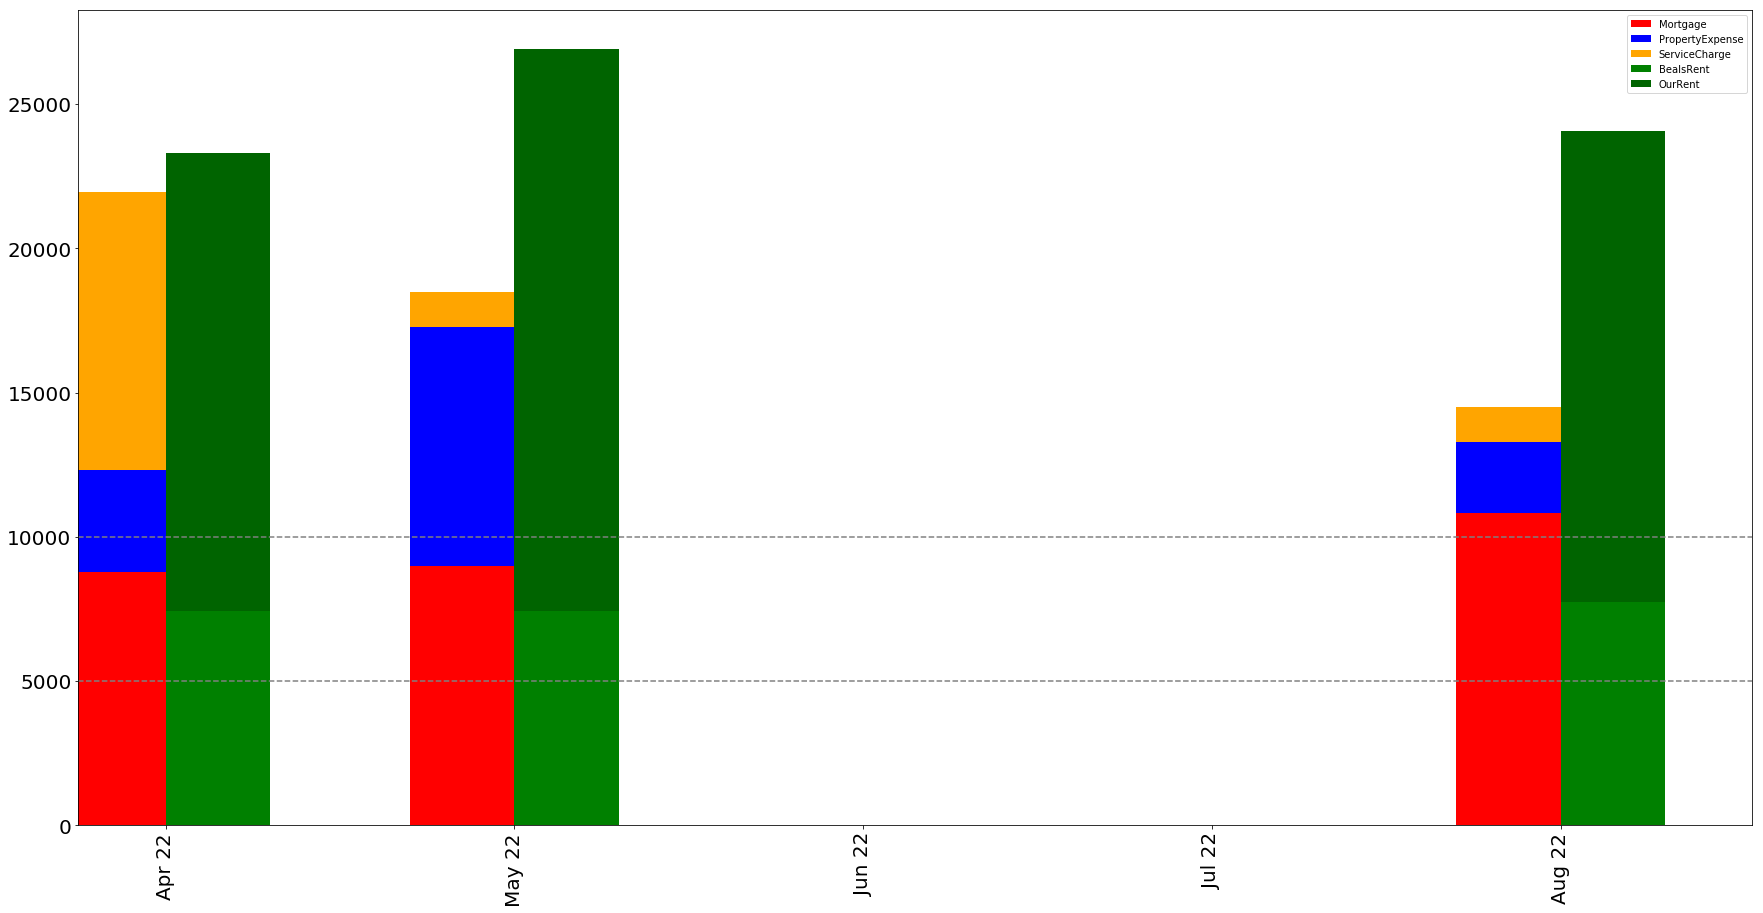

In [290]:
plot_properties(dfPty, '2012-01-01','2022-08-31')

In [259]:
dfMt.to_csv('dfMt.csv')
dfIv.to_csv('dfIv.csv')
dfRsa.to_csv('dfRsa.csv')